In [32]:
import boto3
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [21]:
!pip install seaborn scikit-learn sagemaker # Execute if import failed

In [23]:
def clean_dataset(df):
    # Define the columns to keep
    columns_to_keep = ['temp', 'location', 'time']
    # Filter the DataFrame to keep only the desired columns
    cleaned_df = df[columns_to_keep]
    return cleaned_df

In [8]:
# Initialize boto3 client
s3_client = boto3.client('s3')

# Define bucket and channel
bucket_name = 'iot-bucket-cydnirn'
dataset_path = 'dataset/Version'

In [27]:
response = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=dataset_path)

In [28]:
objects = response.get('Contents', [])
latest_object = max(objects, key=lambda x: x['LastModified'])
latest_object_key = latest_object['Key']

In [29]:
csv_obj = s3_client.get_object(Bucket=bucket_name, Key=latest_object_key)
csv_data = csv_obj['Body'].read().decode('utf-8')

In [30]:
# Load the CSV data into a pandas DataFrame
data = pd.read_csv(StringIO(csv_data))
data = clean_dataset(data)
print(data.head())

   temp location                        time
0    33  Jakarta  2024-06-02T22:02:31.666759
1    40  Jakarta  2024-06-02T22:05:31.698154
2    32  Jakarta  2024-06-02T22:04:01.681902
3    43  Jakarta  2024-06-02T22:13:31.789782
4    33  Jakarta  2024-06-02T22:14:01.795624


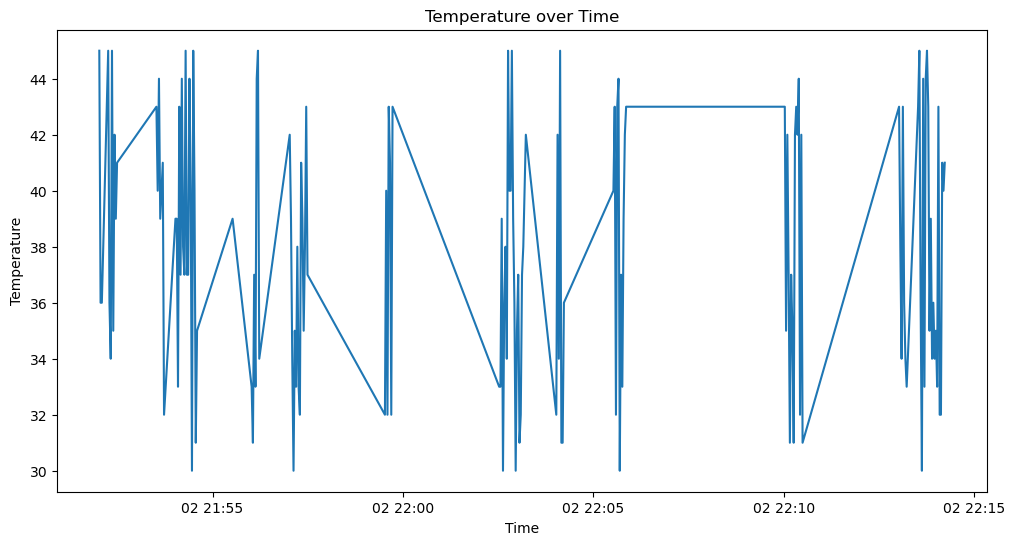

In [31]:
# Convert 'time' column to datetime
data['time'] = pd.to_datetime(data['time'])

# Plot the temperature over time
plt.figure(figsize=(12, 6))
sns.lineplot(x='time', y='temp', data=data)
plt.title('Temperature over Time')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.show()

In [36]:
data['time'] = data['time'].astype('int64') // 10**9  # Convert time to seconds since epoch
X = data[['time', 'location']]  # Features
y = data['temp']  # Target

In [37]:
# Encode 'location' as categorical variables
X = pd.get_dummies(X, columns=['location'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [38]:
# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model
score = model.score(X_test, y_test)
print(f'Model R^2 score: {score:.2f}')

Model R^2 score: -0.00


In [51]:
import sagemaker
import tarfile
from sagemaker.sklearn import SKLearnModel

# Save the model
import joblib
joblib.dump(model, 'model.joblib')

# Define an execution role
role = 'arn:aws:iam::284845684968:role/service-role/AmazonSageMaker-ExecutionRole-20240602T140893'

In [55]:
# Create Tar file

with tarfile.open('model.tar.gz', 'w:gz') as tar:
    tar.add('model.joblib')

In [56]:
# Upload to S3
s3_client.upload_file("model.tar.gz", bucket_name, "model/model.tar.gz")
s3_model_path = 's3://{}/model/model.tar.gz'.format(bucket_name)

In [58]:
# Create a SageMaker SKLearn model
sklearn_model = SKLearnModel(model_data=s3_model_path, role=role, entry_point='inference.py', py_version="py3",  framework_version='0.23-1', name="Iot-model")  # Ensure 'inference.py' is created for prediction

# Deploy the model
predictor = sklearn_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

-----!

In [59]:
# Example of making predictions
data_sample = X_test.iloc[0:1]  # Use a sample from test set
prediction = predictor.predict(data_sample)
print(f'Predicted temperature: {prediction}')

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (500) from primary with message "<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">
<title>500 Internal Server Error</title>
<h1>Internal Server Error</h1>
<p>The server encountered an internal error and was unable to complete your request. Either the server is overloaded or there is an error in the application.</p>
". See https://ap-southeast-2.console.aws.amazon.com/cloudwatch/home?region=ap-southeast-2#logEventViewer:group=/aws/sagemaker/Endpoints/Iot-model-2024-06-02-17-46-47-751 in account 284845684968 for more information.